In [2]:
"""
Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
Adopting to other backends should be easy, but I have not tested this. 

Usage:
       python CapsNet.py
       python CapsNet.py --epochs 100
       python CapsNet.py --epochs 100 --num_routing 3
       ... ...d
       
Result:
    Validation accuracy > 99.5% after 20 epochs. Still under-fitting.
    About 110 seconds per epoch on a single GTX1070 GPU card
    
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask


def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args["save_dir"] + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args["save_dir"] + '/tensorboard-logs',
                               batch_size=args["batch_size"], histogram_freq=args["debug"])
    checkpoint = callbacks.ModelCheckpoint(args["save_dir"] + '/weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args["lr"] * (0.95 ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args["lr"]),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args["lam_recon"]],
                  metrics={'out_caps': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args["batch_size"], epochs=args["epochs"],
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction,
                                           horizontal_flip=True)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args["batch_size"], args["shift_fraction"]),
                        steps_per_epoch=int(y_train.shape[0] / args["batch_size"]),
                        epochs=args["epochs"],
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args["save_dir"] + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args["save_dir"])

    from utils import plot_log
    plot_log(args["save_dir"] + '/log.csv', show=True)

    return model


def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    import matplotlib.pyplot as plt
    from utils import combine_images
    from PIL import Image

    img = combine_images(np.concatenate([x_test[:50], x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
    print()
    print('Reconstructed images are saved to ./real_and_recon.png')
    print('-'*50)
    plt.imshow(plt.imread("real_and_recon.png", ))
    plt.show()


def load_data(path):
    import gzip
    import pandas as pd
    from sklearn.utils import shuffle
    train_file = gzip.GzipFile(path + "fashion-mnist_train.csv.tar.gz", "r")
    with open(path + "fashion-mnist_train.csv", 'wb') as f:
        f.write(train_file.read())
    data_train = pd.read_csv(path + 'fashion-mnist_train.csv')
    data_train = data_train.drop(index=len(data_train.iloc[:, 0])-1) # 不知为什么, 最后一行全为nan, 因此删去末行.
    os.remove(path + 'fashion-mnist_train.csv')
    data_test = pd.read_csv(path + 'fashion-mnist_test.csv')
    x_train = shuffle(np.array(data_train.iloc[:, 1:]))
    x_train = x_train.reshape(x_train.shape[0], int(np.sqrt(x_train.shape[1])), int(np.sqrt(x_train.shape[1])), 1)
    x_test = shuffle(np.array(data_test.iloc[:, 1:]))
    x_test = x_test.reshape(x_test.shape[0], int(np.sqrt(x_test.shape[1])), int(np.sqrt(x_test.shape[1])), 1)
    y_train = shuffle(to_categorical(np.array(data_train.iloc[:, 0])))
    y_test = shuffle(to_categorical(np.array(data_test.iloc[:, 0])))

    return (x_train, y_train), (x_test, y_test)

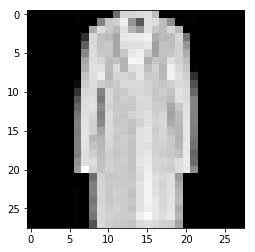

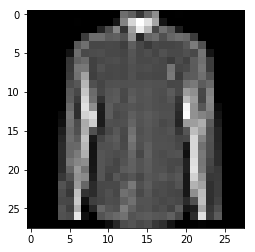

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_3[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

ResourceExhaustedError: OOM when allocating tensor with shape[100,1152,10,1,16]
	 [[Node: digitcaps_1/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](digitcaps_1/transpose_1, digitcaps_1/scan/TensorArrayStack/TensorArrayGatherV3)]]
	 [[Node: loss_1/out_recon_loss/Mean_3/_285 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2129_loss_1/out_recon_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'digitcaps_1/mul', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-e4ee90363634>", line 36, in <module>
    num_routing=args["num_routing"])
  File "<ipython-input-2-256587a916a7>", line 42, in CapsNet
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/a/17b-ZhengPeng-2015/FashionMNIST_Challenge/CapsNet-Fashion-MNIST/capsulelayers.py", line 157, in call
    outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1117, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2726, in _mul
    "Mul", x=x, y=y, name=name)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/a/.virtualenvs/tf_cv_cuda8_cudnn6_geforce940m/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,1152,10,1,16]
	 [[Node: digitcaps_1/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](digitcaps_1/transpose_1, digitcaps_1/scan/TensorArrayStack/TensorArrayGatherV3)]]
	 [[Node: loss_1/out_recon_loss/Mean_3/_285 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2129_loss_1/out_recon_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [4]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

# setting the hyper parameters
args = {
    "batch_size": 100,
    "epochs": 100,
    "lam_recon": 0.392,
    "num_routing": 3,
    "shift_fraction": 0.1,
    "debug": 0,
    "save_dir":'./result',
    "is_training": 1,
    "weights": None,
    "lr": 0.001,
    "data_path": "../MNIST_data/fashion_csv/"
}

if not os.path.exists(args["save_dir"]):
    os.makedirs(args["save_dir"])

# load data
(x_train, y_train), (x_test, y_test) = load_data(args["data_path"])

# define model
model = CapsNet(input_shape=[28, 28, 1],
                n_class=len(np.unique(np.argmax(y_train, 1))),
                num_routing=args["num_routing"])
model.summary()

# train or test
if args["weights"] is not None:  # init the model weights with provided one
    model.load_weights(args["weights"])
if args["is_training"]:
    train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)
else:  # as long as weights are given, will run testing
    if args["weights"] is None:
        print('No weights are provided. Will test using random initialized weights.')
    test(model=model, data=(x_test, y_test))